# 부산광역시 쓰레기 배출량 예측 pt.1

---

<br>

## 00. 기본 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

# 경고 메시지는 출력 X
import warnings
warnings.filterwarnings("ignore")

In [226]:
# 한글 font 설정

import platform
import matplotlib.font_manager as fm

#matplotlib 패키지 한글 깨짐 처리
#------------------------------------------------------------------------------------
# 운영체제별 한글 폰트 설정

if platform.system() == 'Darwin':           # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':        # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [227]:
# 글씨 선명하게 출력하는 설정

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

<Axes: title={'center': '한글타이틀'}>

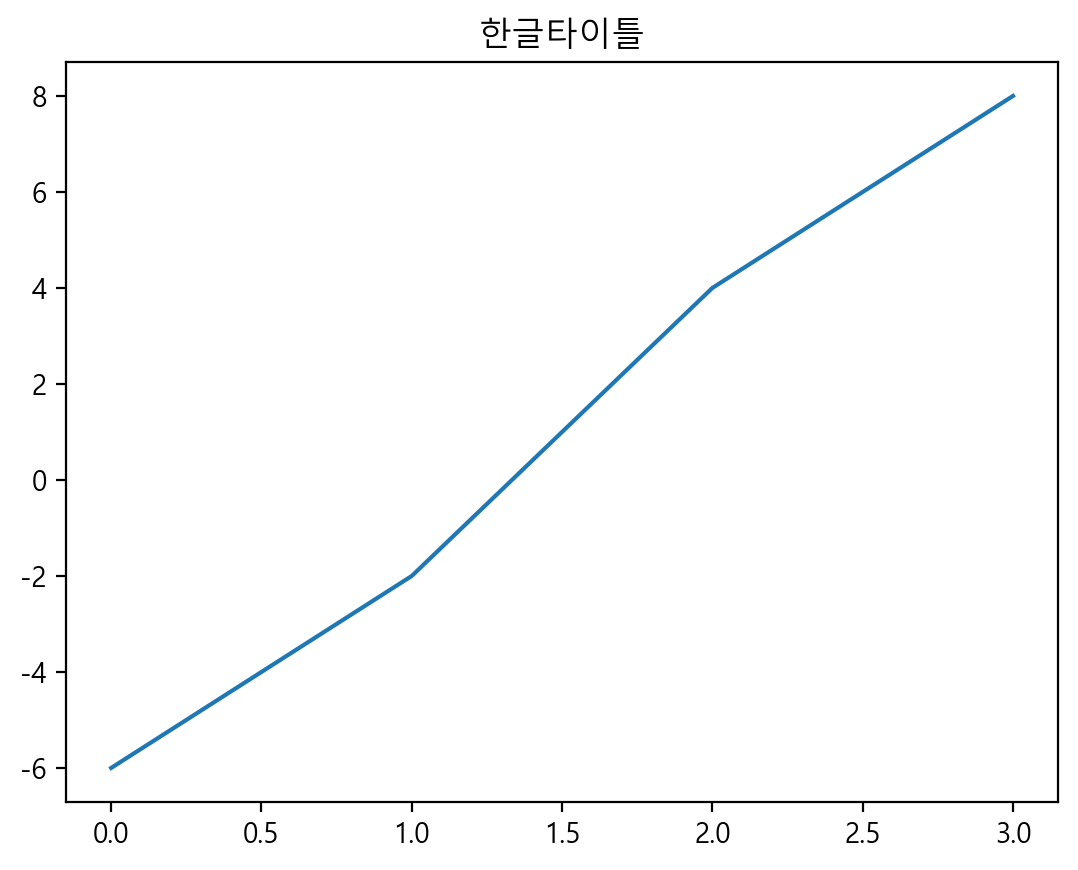

In [228]:
# 한글폰트와 마이너스 폰트 설정 확인

pd.Series([-6, -2, 4, 8]).plot(title="한글타이틀")

<br><br>

---

## 01. 폐기물 데이터

In [229]:
## 폐기물 데이터
waste = pd.read_csv("자원순환정보시스템_시군구별_폐기물배출량.csv", encoding="cp949")

print(f"waste shape: {waste.shape}")
waste

waste shape: (1396, 4)


,연도,시ㆍ도,시군구,배출량(톤/년)
0,2024,서울,종로구,"31,941.99"
1,2024,서울,중구,"39,154.08"
2,2024,서울,용산구,"31,272.54"
3,2024,서울,성동구,"25,274.96"
4,2024,서울,광진구,"25,437.48"
...,...,...,...,...
1391,2019,경남,함양군,"8,019.72"
1392,2019,경남,거창군,"14,227.88"
1393,2019,경남,합천군,"8,027.84"
1394,2019,제주,제주시,"66,896.53"


In [230]:
waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   연도        1396 non-null   int64 
 1   시ㆍ도       1396 non-null   object
 2   시군구       1396 non-null   object
 3   배출량(톤/년)  1396 non-null   object
dtypes: int64(1), object(3)
memory usage: 43.8+ KB


In [231]:
# '-' 를 NaN 으로 변경
waste['배출량(톤/년)'] = waste['배출량(톤/년)'].replace(' - ', np.nan)

# 쉼표 제거 후 float으로 변경
waste['배출량(톤/년)'] = waste['배출량(톤/년)'].str.replace(',', '').astype(float)
waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   연도        1396 non-null   int64  
 1   시ㆍ도       1396 non-null   object 
 2   시군구       1396 non-null   object 
 3   배출량(톤/년)  1357 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 43.8+ KB


In [232]:
# '지역' col 생성
waste['지역'] = waste['시ㆍ도'].str.strip() + '_' + waste['시군구'].str.strip()
waste2 = waste.copy()

# '지역' col을 첫 번째로 이동
cols = waste2.columns.tolist()
cols = ['지역'] + [col for col in cols if col != '지역']
waste2 = waste2[cols]

waste2.head(3)

,지역,연도,시ㆍ도,시군구,배출량(톤/년)
0,서울_종로구,2024,서울,종로구,31941.99
1,서울_중구,2024,서울,중구,39154.08
2,서울_용산구,2024,서울,용산구,31272.54


In [233]:
# waste2.to_csv("시군구별_폐기물배출량.csv", encoding='cp949')

In [234]:
waste2.describe()

,연도,배출량(톤/년)
count,1396.000000,1357.000000
mean,2021.497135,26947.744141
std,1.707875,27556.936123
min,2019.000000,0.000000
25%,2020.000000,8029.640000
50%,2021.000000,18773.550000
75%,2023.000000,36800.330000
max,2024.000000,148832.210000


In [235]:
# null 값 count
null_counts = waste2[waste2['배출량(톤/년)'].isnull()].groupby('시ㆍ도').size()

# 0.0 값 count
zero_counts = waste2[waste2['배출량(톤/년)'] == 0.0].groupby('시ㆍ도').size()

# 결과 출력
print(f"""시도별 null 값 개수 total: {sum(null_counts)}""")
print(f"""시도별 0.0 값 개수 total: {sum(zero_counts)}""")

시도별 null 값 개수 total: 39
시도별 0.0 값 개수 total: 73


In [236]:
# waste2에서 "출장소" 또는 "경제청" 포함된 행 삭제
waste_clean = waste2[~waste2['시군구'].str.contains('출장소|경제청')]
print(f"제거 후 shape: {waste_clean.shape}")

# 기존: (1396, 4)
waste_clean.head()

제거 후 shape: (1374, 5)


,지역,연도,시ㆍ도,시군구,배출량(톤/년)
0,서울_종로구,2024,서울,종로구,31941.99
1,서울_중구,2024,서울,중구,39154.08
2,서울_용산구,2024,서울,용산구,31272.54
3,서울_성동구,2024,서울,성동구,25274.96
4,서울_광진구,2024,서울,광진구,25437.48


<br><br>

---
## a) 시각화

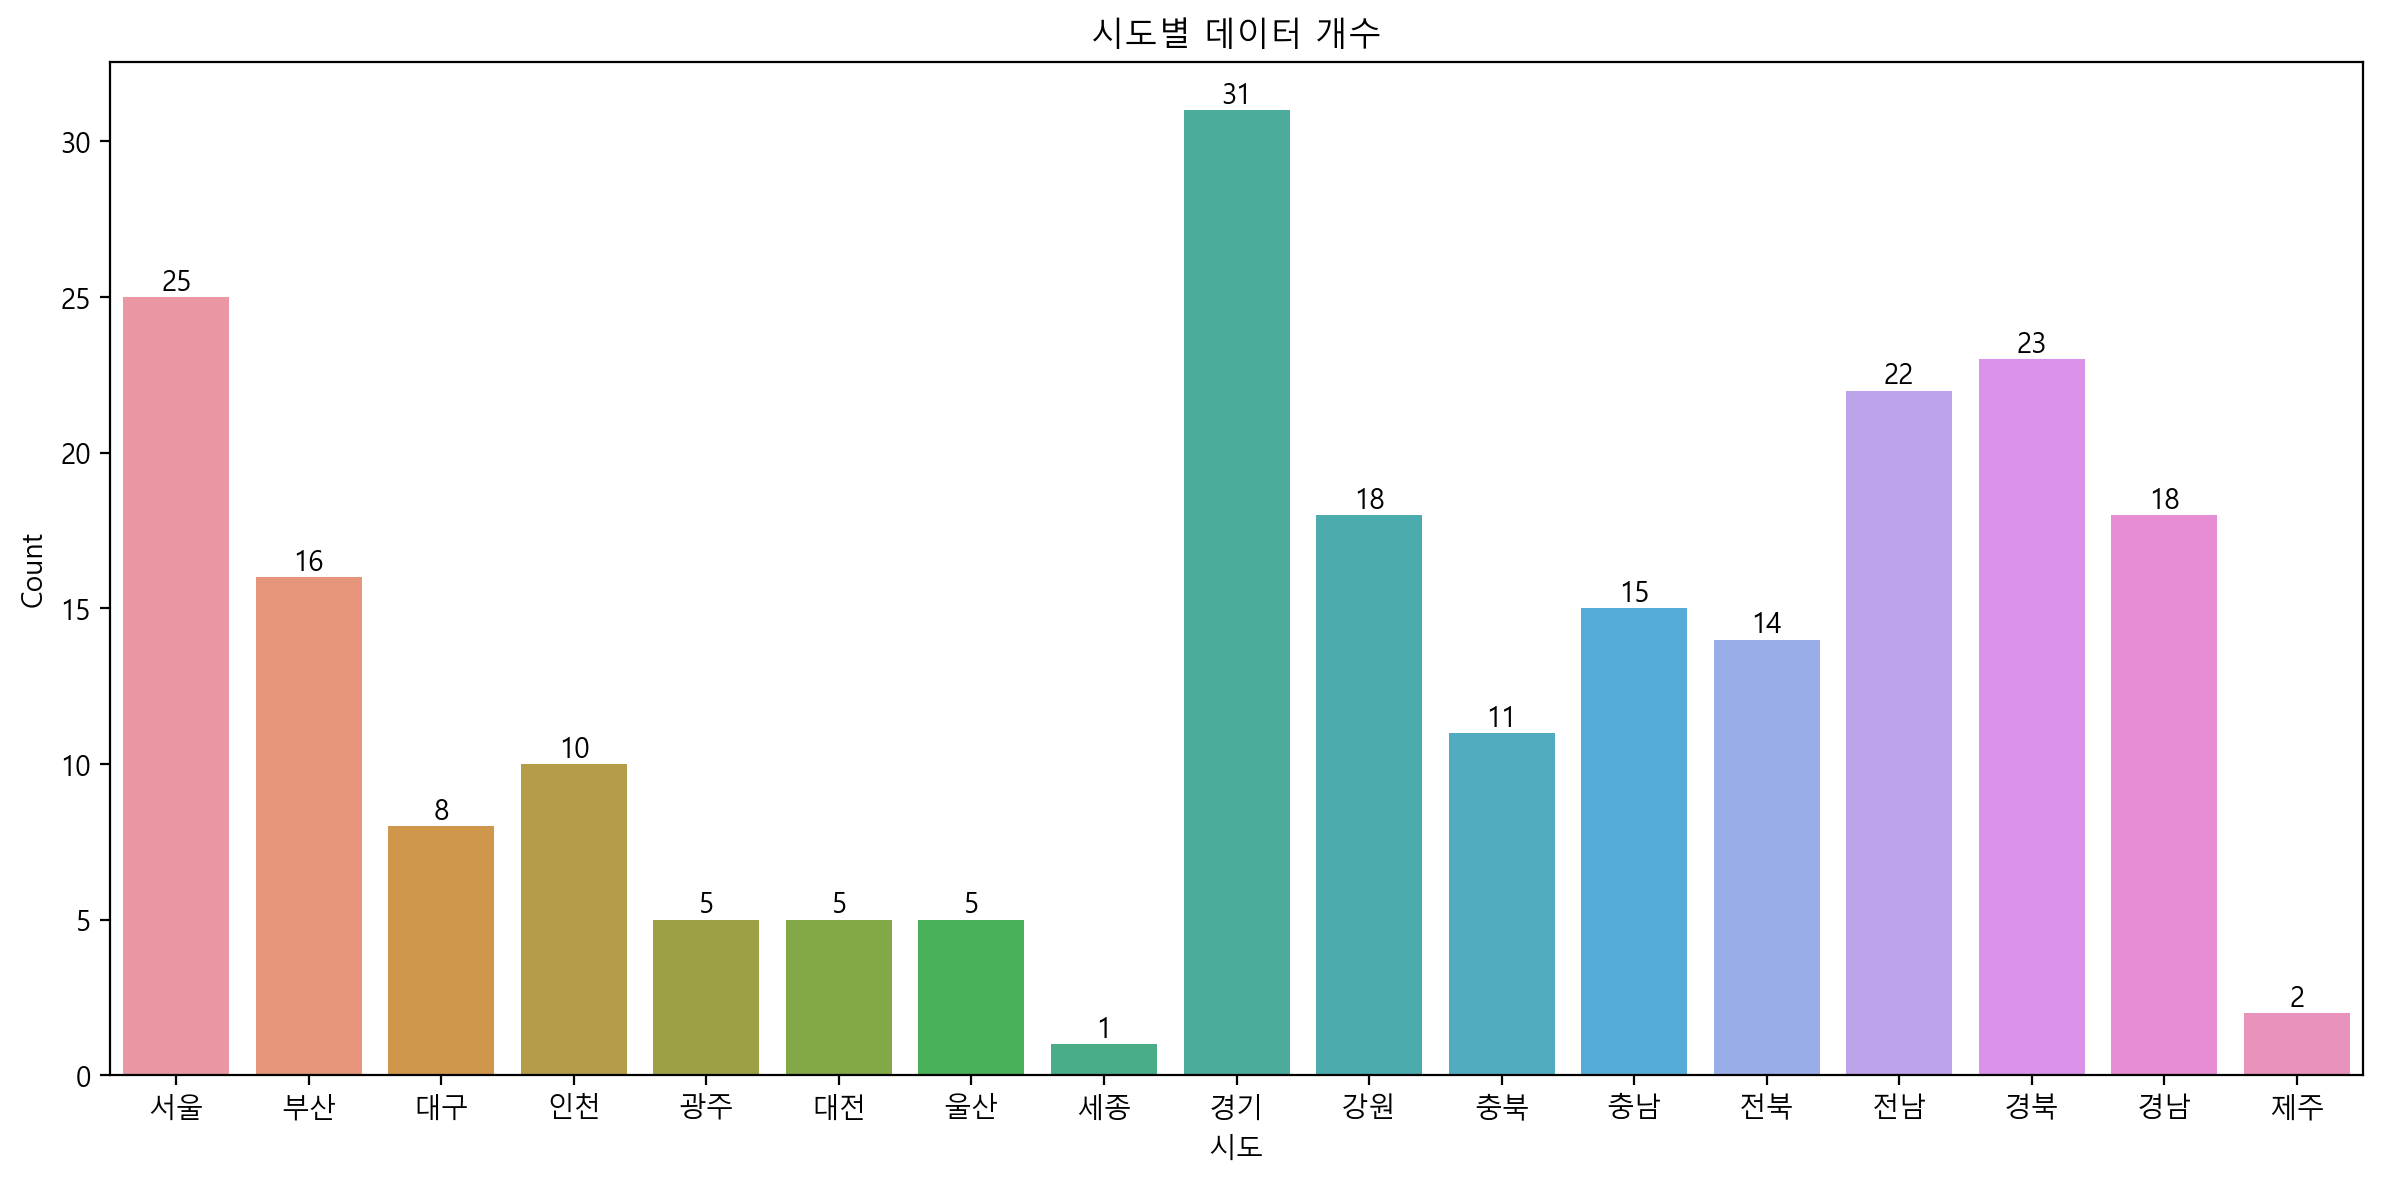

In [237]:
# 시도별 countplot
waste_year = waste_clean[waste_clean['연도'] == 2021]

plt.figure(figsize=(12, 6))  # 그래프 크기 설정 (원하는 크기로 변경 가능)
ax = sns.countplot(data=waste_year, x='시ㆍ도')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title('시도별 데이터 개수')
plt.xlabel('시도')
plt.ylabel('Count')
plt.tight_layout()

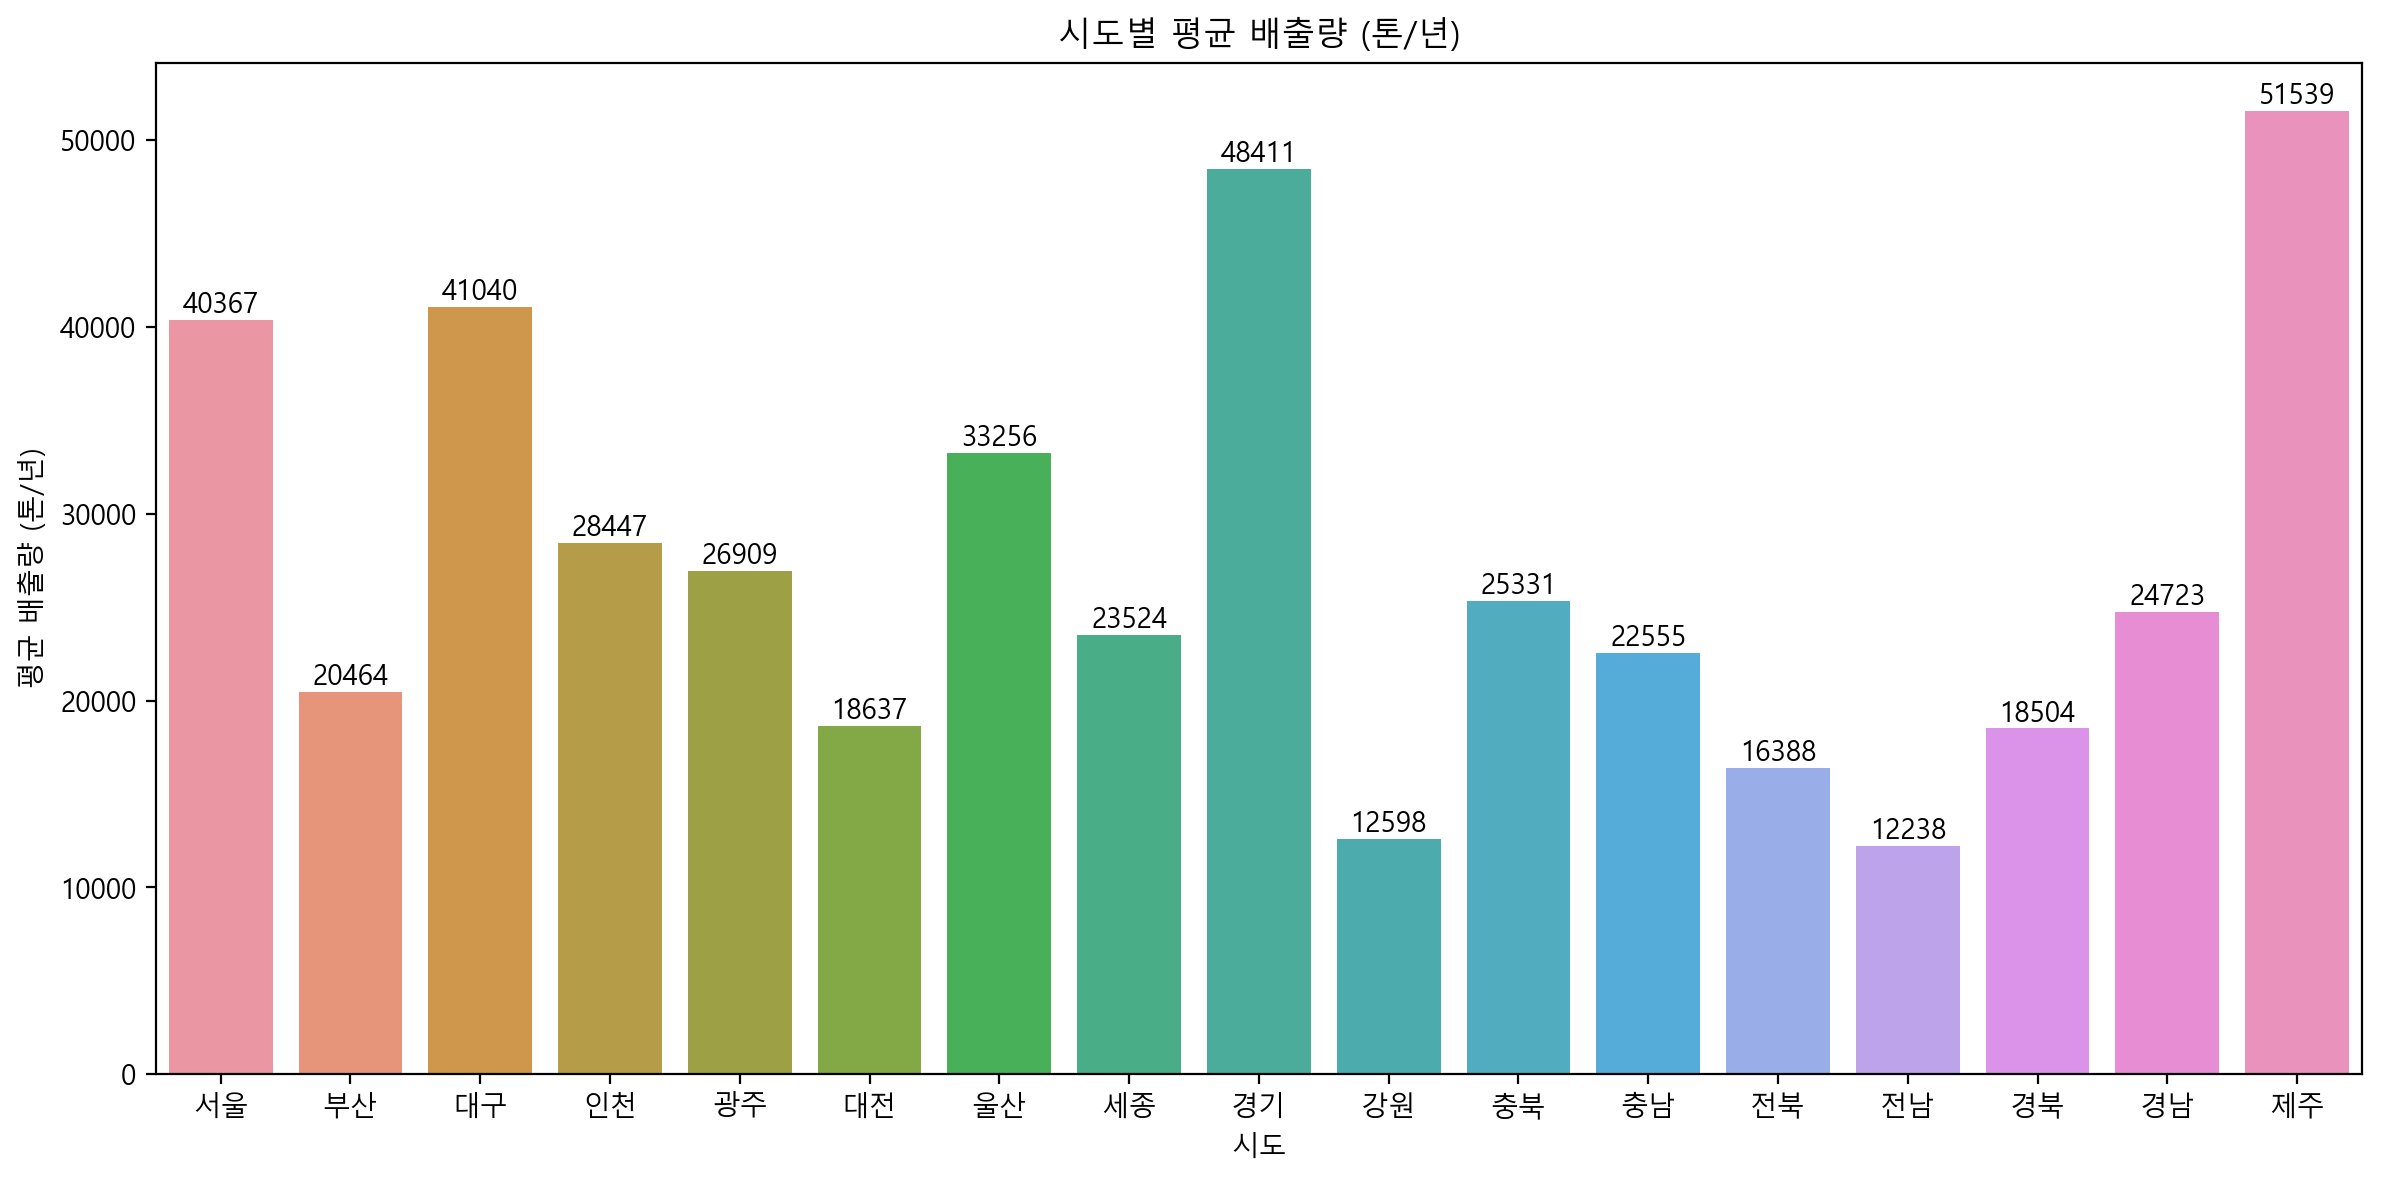

In [238]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=waste_clean, x='시ㆍ도', y='배출량(톤/년)', estimator='mean', ci=None)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title('시도별 평균 배출량 (톤/년)')
plt.xlabel('시도')
plt.ylabel('평균 배출량 (톤/년)')
plt.tight_layout()

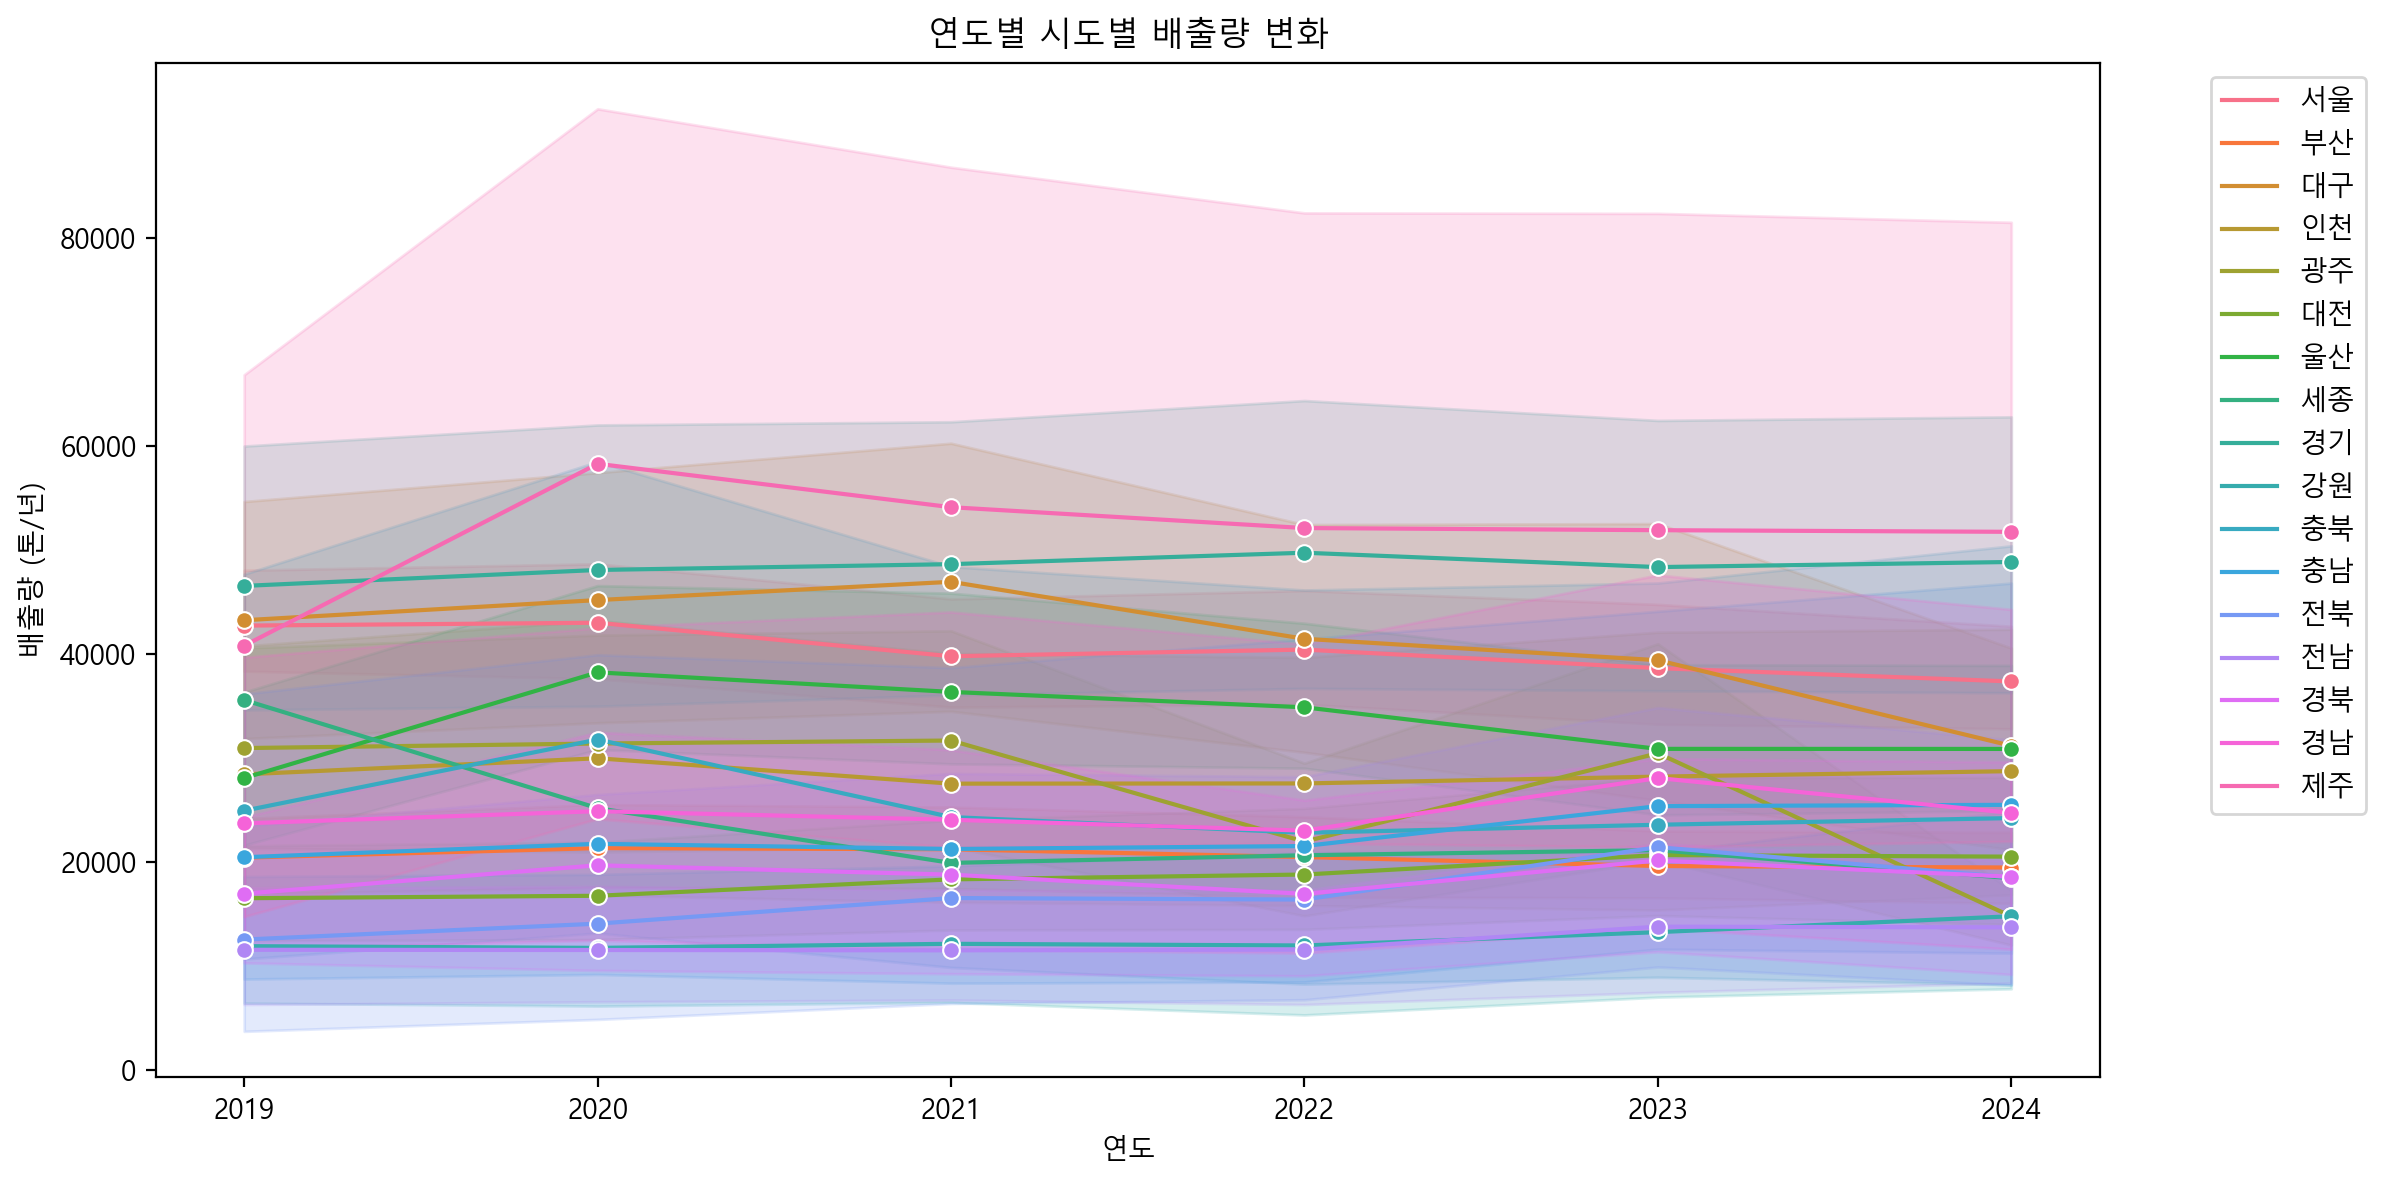

In [239]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=waste_clean, x='연도', y='배출량(톤/년)', hue='시ㆍ도', marker='o')

plt.title('연도별 시도별 배출량 변화')
plt.xlabel('연도')
plt.ylabel('배출량 (톤/년)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

<br><br>

---
## 02. 주민등록세대수 데이터

In [240]:
## 주민등록세대수 데이터
household = pd.read_csv("행정구역_시군구_별_주민등록세대수_20250612042813.csv", encoding="cp949")

print(f"household shape: {household.shape}")
household

household shape: (1617, 4)


,시점,시ㆍ도,행정구역(시군구)별,데이터
0,2019,서울,종로구,73947
1,2019,서울,중구,62739
2,2019,서울,용산구,110126
3,2019,서울,성동구,135838
4,2019,서울,광진구,164428
...,...,...,...,...
1612,2024,경남,함양군,20471
1613,2024,경남,거창군,31129
1614,2024,경남,합천군,23687
1615,2024,제주,제주시,225846


In [241]:
# 데이터 칼럼명 먼저 정리
household = household.rename(columns={
    '시점': '연도',
    '행정구역(시군구)별': '시군구',
    '데이터': '세대수'
})
household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연도      1617 non-null   int64 
 1   시ㆍ도     1617 non-null   object
 2   시군구     1617 non-null   object
 3   세대수     1617 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 50.7+ KB


In [242]:
# "출장소" 또는 "경제청" 포함된 행 삭제
household_clean = household[~household['시군구'].str.contains('출장소|경제청')]
household_clean.shape

# 기존: (1617, 4)

(1569, 4)

In [243]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_clean['시군구'].unique()) - set(household_clean['시군구'].unique()))
print(set(household_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
{'팔달구', '상당구', '원미구', '성산구', '처인구', '만안구', '상록구', '마산합포구', '덕양구', '진해구', '기흥구', '마산회원구', '의창구', '동안구', '영통구', '흥덕구', '일산동구', '덕진구', '수정구', '수지구', '장안구', '청원구', '완산구', '권선구', '분당구', '단원구', '중원구', '오정구', '서원구', '소사구', '일산서구', '동남구', '서북구'}


#### 변경 list
- '오정구', '소사구', '원미구': '경기 부천시'
- '완산구', '덕진구': '전북 전주시'
- '상록구', '단원구': '경기 안산시'
- '일산동구', '덕양구', '일산서구': '경기 고양시'
- '성산구', '마산합포구', '진해구', '마산회원구', '의창구': '경남 창원시'
- '상당구', '청원구', '흥덕구', '서원구': '충북 청주시'
- '만안구', '동안구': '경기 안양시'
- '수지구', '처인구', '기흥구': '경기 용인시'
- '영통구', '권선구', '장안구', '팔달구': '경기 수원시'
- '분당구', '중원구', '수정구': '경기 성남시'
- '동남구', '서북구': '충남 천안시'

In [244]:
시군구_매핑 = {
    '오정구': '부천시',
    '소사구': '부천시',
    '원미구': '부천시',
    '완산구': '전주시',
    '덕진구': '전주시',
    '상록구': '안산시',
    '단원구': '안산시',
    '일산동구': '고양시',
    '덕양구': '고양시',
    '일산서구': '고양시',
    '성산구': '창원시',
    '마산합포구': '창원시',
    '진해구': '창원시',
    '마산회원구': '창원시',
    '의창구': '창원시',
    '상당구': '청주시',
    '청원구': '청주시',
    '흥덕구': '청주시',
    '서원구': '청주시',
    '만안구': '안양시',
    '동안구': '안양시',
    '수지구': '용인시',
    '처인구': '용인시',
    '기흥구': '용인시',
    '영통구': '수원시',
    '권선구': '수원시',
    '장안구': '수원시',
    '팔달구': '수원시',
    '분당구': '성남시',
    '중원구': '성남시',
    '수정구': '성남시',
    '동남구': '천안시',
    '서북구': '천안시'
}

# population의 시군구명 변경
household_clean['시군구'] = household_clean['시군구'].replace(시군구_매핑)

In [245]:
# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
household_clean = household_clean.groupby(['연도', '시ㆍ도', '시군구'], as_index=False).sum(numeric_only=True)
household_clean.head()

,연도,시ㆍ도,시군구,세대수
0,2019,강원,강릉시,99086
1,2019,강원,고성군,14445
2,2019,강원,동해시,41141
3,2019,강원,삼척시,34082
4,2019,강원,속초시,38689


In [246]:
# 다시 확인
print(set(waste_clean['시군구'].unique()) - set(household_clean['시군구'].unique()))
print(set(household_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
set()


In [247]:
# '지역' 열 생성 (형식: "시ㆍ도_시군구")
household_clean['지역'] = household_clean['시ㆍ도'] + '_' + household_clean['시군구']

print(f"household_clean shape: {household_clean.shape}")
household_clean.head(3)

# waste_clean: (1374, 5)
# household_clean: (1386, 5)

household_clean shape: (1386, 5)


,연도,시ㆍ도,시군구,세대수,지역
0,2019,강원,강릉시,99086,강원_강릉시
1,2019,강원,고성군,14445,강원_고성군
2,2019,강원,동해시,41141,강원_동해시


In [248]:
# household_clean.to_csv("세대수.csv", encoding="cp949", , index=False)

<br><br>

---
## 03. 인구 수 데이터

In [249]:
## 주민등록세대수 데이터
population = pd.read_csv("행정구역_시군구_별_인구수_20250612171906.csv", encoding="cp949")

print(f"population shape: {population.shape}")
population.head()

population shape: (1569, 4)


,시ㆍ도,시군구,연도,총인구수 (명)
0,서울,종로구,2019,151290
1,서울,종로구,2020,149384
2,서울,종로구,2021,144683
3,서울,종로구,2022,141379
4,서울,종로구,2023,139417


In [250]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   시ㆍ도       1569 non-null   object
 1   시군구       1569 non-null   object
 2   연도        1569 non-null   int64 
 3   총인구수 (명)  1569 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 49.2+ KB


In [251]:
# "출장소" 또는 "경제청" 포함된 행 삭제
population_clean = population[~population['시군구'].str.contains('출장소|경제청')]
population_clean.shape

# 기존: (1569, 4)

(1569, 4)

In [252]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_clean['시군구'].unique()) - set(population_clean['시군구'].unique()))
print(set(population_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
{'팔달구', '상당구', '원미구', '성산구', '처인구', '만안구', '상록구', '마산합포구', '덕양구', '진해구', '기흥구', '마산회원구', '의창구', '동안구', '영통구', '흥덕구', '일산동구', '덕진구', '수정구', '수지구', '장안구', '청원구', '완산구', '권선구', '분당구', '단원구', '중원구', '오정구', '서원구', '소사구', '일산서구', '동남구', '서북구'}


In [253]:
# population의 시군구명 변경
population_clean['시군구'] = population_clean['시군구'].replace(시군구_매핑)

# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
population_clean = population_clean.groupby(['연도', '시ㆍ도', '시군구'], as_index=False).sum(numeric_only=True)
population_clean.head()

,연도,시ㆍ도,시군구,총인구수 (명)
0,2019,강원,강릉시,213442
1,2019,강원,고성군,27260
2,2019,강원,동해시,90522
3,2019,강원,삼척시,67228
4,2019,강원,속초시,81786


In [254]:
# 다시 확인
print(set(waste_clean['시군구'].unique()) - set(population_clean['시군구'].unique()))
print(set(population_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
set()


In [255]:
# '지역' 열 생성 (형식: "시ㆍ도_시군구")
population_clean['지역'] = population_clean['시ㆍ도'] + '_' + population_clean['시군구']

print(f"population_clean shape: {population_clean.shape}")
population_clean.head(3)

# waste_clean: (1374, 5)
# household_clean: (1386, 5)
# population_clean: (1386, 5)

population_clean shape: (1386, 5)


,연도,시ㆍ도,시군구,총인구수 (명),지역
0,2019,강원,강릉시,213442,강원_강릉시
1,2019,강원,고성군,27260,강원_고성군
2,2019,강원,동해시,90522,강원_동해시


In [256]:
# population_clean.to_csv("인구수.csv", encoding="cp949", , index=False)

<br><br>

---
## 04. 1인가구 수 및 비율 데이터

In [257]:
## 주민등록세대수 데이터
single = pd.read_csv("행정구역_시군구_별_1인가구_20250613020741.csv", encoding="cp949")

print(f"single shape: {single.shape}")
single.head()

single shape: (1305, 4)


,시ㆍ도,시군구,연도,1인가구
0,서울,종로구,2019,24671
1,서울,종로구,2020,25983
2,서울,종로구,2021,27308
3,서울,종로구,2022,28424
4,서울,종로구,2023,29334


In [258]:
single.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시ㆍ도     1305 non-null   object
 1   시군구     1305 non-null   object
 2   연도      1305 non-null   int64 
 3   1인가구    1305 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 40.9+ KB


In [259]:
# "출장소" 또는 "경제청" 포함된 행 삭제
single_clean = single[~single['시군구'].str.contains('출장소|경제청')]
single_clean.shape

# 기존: (1305, 4)

(1305, 4)

In [260]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_clean['시군구'].unique()) - set(single_clean['시군구'].unique()))
print(set(single_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
{'팔달구', '상당구', '성산구', '처인구', '만안구', '상록구', '마산합포구', '덕양구', '진해구', '기흥구', '마산회원구', '의창구', '동안구', '영통구', '흥덕구', '일산동구', '덕진구', '수정구', '수지구', '장안구', '청원구', '완산구', '권선구', '분당구', '단원구', '중원구', '서원구', '일산서구', '동남구', '서북구'}


In [261]:
# population의 시군구명 변경
single_clean['시군구'] = single_clean['시군구'].replace(시군구_매핑)

# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
single_clean = single_clean.groupby(['연도', '시ㆍ도', '시군구'], as_index=False).sum(numeric_only=True)
single_clean.head()

,연도,시ㆍ도,시군구,1인가구
0,2019,강원,강릉시,32119
1,2019,강원,고성군,3823
2,2019,강원,동해시,10543
3,2019,강원,삼척시,10834
4,2019,강원,속초시,11111


In [262]:
# 다시 확인
print(set(waste_clean['시군구'].unique()) - set(single_clean['시군구'].unique()))
print(set(single_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
set()


In [263]:
# '지역' 열 생성 (형식: "시ㆍ도_시군구")
single_clean['지역'] = single_clean['시ㆍ도'] + '_' + single_clean['시군구']

print(f"single_clean shape: {single_clean.shape}")
single_clean.head(3)

# waste_clean: (1374, 5)
# household_clean: (1386, 5)
# population_clean: (1386, 5)
# single_clean: (1155, 5)

single_clean shape: (1155, 5)


,연도,시ㆍ도,시군구,1인가구,지역
0,2019,강원,강릉시,32119,강원_강릉시
1,2019,강원,고성군,3823,강원_고성군
2,2019,강원,동해시,10543,강원_동해시


<br>

### 비율 계산
- single_clean 데이터프레임에 1인가구비율 열 추가
- 1인가구 / 세대수(`household_clean df`)
- 연도-지역 기준으로 household_clean의 세대수와 매칭
- *2024년 데이터는 single_clean에 없으므로 → 1인가구비율 = NaN 처리

In [264]:
# 필요한 컬럼만 사용
household_subset = household_clean[['연도', '지역', '세대수']]

# single_clean에 세대수 붙이기 (left join → single_clean 기준 유지)
single_with_household = pd.merge(single_clean, household_subset, on=['연도', '지역'], how='left')

# 비율 계산 (세대수가 0인 경우는 division by zero 방지)
single_with_household['single_1인가구비율'] = round(single_with_household['1인가구'] / single_with_household['세대수'], 3)
single_with_household.head()

,연도,시ㆍ도,시군구,1인가구,지역,세대수,single_1인가구비율
0,2019,강원,강릉시,32119,강원_강릉시,99086,0.324
1,2019,강원,고성군,3823,강원_고성군,14445,0.265
2,2019,강원,동해시,10543,강원_동해시,41141,0.256
3,2019,강원,삼척시,10834,강원_삼척시,34082,0.318
4,2019,강원,속초시,11111,강원_속초시,38689,0.287


In [265]:
single_filtered = single_with_household.drop("1인가구", axis=1)
single_filtered.head()

,연도,시ㆍ도,시군구,지역,세대수,single_1인가구비율
0,2019,강원,강릉시,강원_강릉시,99086,0.324
1,2019,강원,고성군,강원_고성군,14445,0.265
2,2019,강원,동해시,강원_동해시,41141,0.256
3,2019,강원,삼척시,강원_삼척시,34082,0.318
4,2019,강원,속초시,강원_속초시,38689,0.287


In [266]:
# single_filtered.to_csv("1인가구수및비율(23년까지).csv", encoding="cp949", , index=False)

<br><br>

---
## 05. 주거형태 데이터

In [267]:
housing = pd.read_csv("행정구역_시군구_별_종류별_주택_20250613023403.csv", encoding="cp949")

print(f"housing shape: {housing.shape}")
housing.head()

housing shape: (1305, 9)


,시ㆍ도,시군구,연도,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택
0,서울,종로구,2019,46440,12421,15290,5459,12349,921
1,서울,종로구,2020,46859,12259,15688,5460,12540,912
2,서울,종로구,2021,46885,11987,15775,5490,12725,908
3,서울,종로구,2022,46810,11823,15923,5532,12651,881
4,서울,종로구,2023,47025,11620,16300,5544,12695,866


In [268]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   시ㆍ도           1305 non-null   object
 1   시군구           1305 non-null   object
 2   연도            1305 non-null   int64 
 3   주택            1305 non-null   int64 
 4   단독주택-계        1305 non-null   int64 
 5   아파트           1305 non-null   int64 
 6   연립주택          1305 non-null   int64 
 7   다세대주택         1305 non-null   int64 
 8   비주거용 건물 내 주택  1305 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 91.9+ KB


In [269]:
# "출장소" 또는 "경제청" 포함된 행 삭제
housing_clean = housing[~housing['시군구'].str.contains('출장소|경제청')]
housing_clean.shape

# 기존: (1305, 9)

(1305, 9)

In [270]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_clean['시군구'].unique()) - set(housing_clean['시군구'].unique()))
print(set(housing_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
{'팔달구', '상당구', '성산구', '처인구', '만안구', '상록구', '마산합포구', '덕양구', '진해구', '기흥구', '마산회원구', '의창구', '동안구', '영통구', '흥덕구', '일산동구', '덕진구', '수정구', '수지구', '장안구', '청원구', '완산구', '권선구', '분당구', '단원구', '중원구', '서원구', '일산서구', '동남구', '서북구'}


In [271]:
# population의 시군구명 변경
housing_clean['시군구'] = housing_clean['시군구'].replace(시군구_매핑)

# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
housing_clean = housing_clean.groupby(['연도', '시ㆍ도', '시군구'], as_index=False).sum(numeric_only=True)
housing_clean.head()

,연도,시ㆍ도,시군구,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택
0,2019,강원,강릉시,85780,29481,50175,2919,1470,1735
1,2019,강원,고성군,11559,8764,2193,109,121,372
2,2019,강원,동해시,38906,10461,24961,1657,1152,675
3,2019,강원,삼척시,30699,13381,14268,1565,920,565
4,2019,강원,속초시,36090,8544,24949,1497,483,617


In [272]:
# 다시 확인
print(set(waste_clean['시군구'].unique()) - set(housing_clean['시군구'].unique()))
print(set(housing_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
set()


In [273]:
# '지역' 열 생성 (형식: "시ㆍ도_시군구")
housing_clean['지역'] = housing_clean['시ㆍ도'] + '_' + housing_clean['시군구']

print(f"housing_clean shape: {housing_clean.shape}")
housing_clean.head(3)

# waste_clean: (1374, 5)      ~'24
# household_clean: (1386, 5)  ~'24
# population_clean: (1386, 5) ~'24
# single_clean: (1155, 5)     ~'23
# housing_clean: (1155, 10)   ~'23

housing_clean shape: (1155, 10)


,연도,시ㆍ도,시군구,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택,지역
0,2019,강원,강릉시,85780,29481,50175,2919,1470,1735,강원_강릉시
1,2019,강원,고성군,11559,8764,2193,109,121,372,강원_고성군
2,2019,강원,동해시,38906,10461,24961,1657,1152,675,강원_동해시


<br>

### 비율 계산

In [274]:
# 통계 먼저 확인
housing_clean.describe()

,연도,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택
count,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000,1155.000000
mean,2021.000000,95010.655411,18537.027706,61616.173160,2666.964502,11150.098701,1040.391342
std,1.414826,121851.555256,16166.213806,93431.561183,3853.690855,20255.662111,1088.529646
min,2019.000000,3008.000000,1437.000000,20.000000,100.000000,26.000000,47.000000
25%,2020.000000,24419.500000,10184.000000,5749.000000,582.000000,602.000000,421.500000
50%,2021.000000,56803.000000,15326.000000,32038.000000,1460.000000,2401.000000,788.000000
75%,2022.000000,118410.500000,21410.000000,77492.000000,3027.500000,11727.500000,1262.000000
max,2023.000000,816880.000000,156244.000000,611466.000000,25148.000000,165262.000000,8178.000000


In [275]:
housing_clean['단독주택비율'] = round(housing_clean['단독주택-계'] / housing_clean['주택'], 4)
housing_clean['아파트비율'] = round(housing_clean['아파트'] / housing_clean['주택'], 4)
housing_clean['연립주택비율'] = round(housing_clean['연립주택'] / housing_clean['주택'], 4)
housing_clean['다세대주택비율'] = round(housing_clean['다세대주택'] / housing_clean['주택'], 4)
housing_clean['비주거용주택비율'] = round(housing_clean['비주거용 건물 내 주택'] / housing_clean['주택'], 4)

housing_clean.head(1)

,연도,시ㆍ도,시군구,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택,지역,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율
0,2019,강원,강릉시,85780,29481,50175,2919,1470,1735,강원_강릉시,0.3437,0.5849,0.034,0.0171,0.0202


In [276]:
# 비율만 남기고 나머지는 삭제
housing_filtered = housing_clean.drop(["주택", "단독주택-계", "아파트", "연립주택","다세대주택", "비주거용 건물 내 주택"], axis=1)
housing_filtered.head()

,연도,시ㆍ도,시군구,지역,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율
0,2019,강원,강릉시,강원_강릉시,0.3437,0.5849,0.0340,0.0171,0.0202
1,2019,강원,고성군,강원_고성군,0.7582,0.1897,0.0094,0.0105,0.0322
2,2019,강원,동해시,강원_동해시,0.2689,0.6416,0.0426,0.0296,0.0173
3,2019,강원,삼척시,강원_삼척시,0.4359,0.4648,0.0510,0.0300,0.0184
4,2019,강원,속초시,강원_속초시,0.2367,0.6913,0.0415,0.0134,0.0171


In [277]:
# housing_filtered.to_csv("주택유형별비율(23년까지).csv", encoding="cp949", , index=False)

<br><br>

---
## 06. 가구원수별_가구 데이터

In [278]:
householdtype = pd.read_csv("행정구역_시군구_별_가구원수별_가구_mj_수정.csv", encoding="cp949")

print(f"householdtype shape: {householdtype.shape}")
householdtype.head()

householdtype shape: (1300, 7)


,행정구역,시점,1인,2인,3인,4인,5인 이상
0,서울_종로구,2019,24671,16208,11154,7828,2791
1,서울_종로구,2020,25983,16281,10882,7679,2589
2,서울_종로구,2021,27308,16320,10690,7367,2299
3,서울_종로구,2022,28424,16471,10570,6943,2014
4,서울_종로구,2023,29334,16191,10490,6570,1922


In [279]:
# 행정구역 이름을 수정하기 위해 "시도"와 "시군구"로 분리
householdtype[['시ㆍ도', '시군구']] = householdtype['행정구역'].str.split('_', expand=True)

# 시군구명 변경
householdtype['시군구'] = householdtype['시군구'].replace(시군구_매핑)

# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
householdtype = householdtype.groupby(['시점', '시ㆍ도', '시군구'], as_index=False).sum(numeric_only=True)
householdtype.head(3)

,시점,시ㆍ도,시군구,1인,2인,3인,4인,5인 이상
0,2019,강원,강릉시,32119,28629,16547,11083,3715
1,2019,강원,고성군,3823,4076,1844,980,409
2,2019,강원,동해시,10543,12086,7172,4833,1580


In [280]:
# "출장소" 또는 "경제청" 포함된 행 삭제
householdtype_clean = householdtype[~householdtype['시군구'].str.contains('출장소|경제청')]
householdtype_clean.shape

(1155, 8)

In [281]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_clean['시군구'].unique()) - set(householdtype_clean['시군구'].unique()))
print(set(householdtype_clean['시군구'].unique()) - set(waste_clean['시군구'].unique()))

set()
set()


In [282]:
householdtype_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시점      1155 non-null   int64 
 1   시ㆍ도     1155 non-null   object
 2   시군구     1155 non-null   object
 3   1인      1155 non-null   int64 
 4   2인      1155 non-null   int64 
 5   3인      1155 non-null   int64 
 6   4인      1155 non-null   int64 
 7   5인 이상   1155 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 72.3+ KB


<br>

### 비율 계산

In [283]:
# 전체 가구 수 계산
householdtype_clean['총가구수'] = householdtype_clean[['1인', '2인', '3인', '4인', '5인 이상']].sum(axis=1)

# 가구원수별 비율 계산
householdtype_clean['1인가구비율'] = round(householdtype_clean['1인'] / householdtype_clean['총가구수'], 4)
householdtype_clean['2인가구비율'] = round(householdtype_clean['2인'] / householdtype_clean['총가구수'], 4)
householdtype_clean['3인가구비율'] = round(householdtype_clean['3인'] / householdtype_clean['총가구수'], 4)
householdtype_clean['4인가구비율'] = round(householdtype_clean['4인'] / householdtype_clean['총가구수'], 4)
householdtype_clean['5인이상가구비율'] = round(householdtype_clean['5인 이상'] / householdtype_clean['총가구수'], 4)

householdtype_clean.head(3)

,시점,시ㆍ도,시군구,1인,2인,3인,4인,5인 이상,총가구수,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
0,2019,강원,강릉시,32119,28629,16547,11083,3715,92093,0.3488,0.3109,0.1797,0.1203,0.0403
1,2019,강원,고성군,3823,4076,1844,980,409,11132,0.3434,0.3662,0.1656,0.0880,0.0367
2,2019,강원,동해시,10543,12086,7172,4833,1580,36214,0.2911,0.3337,0.1980,0.1335,0.0436


In [284]:
# 비율만 남기고 나머지는 삭제
householdtype_filtered = householdtype_clean.drop(["1인", "2인", "3인", "4인", "5인 이상", "총가구수"], axis=1)
householdtype_filtered.head()

,시점,시ㆍ도,시군구,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
0,2019,강원,강릉시,0.3488,0.3109,0.1797,0.1203,0.0403
1,2019,강원,고성군,0.3434,0.3662,0.1656,0.0880,0.0367
2,2019,강원,동해시,0.2911,0.3337,0.1980,0.1335,0.0436
3,2019,강원,삼척시,0.3690,0.3315,0.1676,0.0979,0.0341
4,2019,강원,속초시,0.3248,0.3272,0.1889,0.1217,0.0375


In [285]:
# '지역' 열 생성 (형식: "시ㆍ도_시군구")
householdtype_filtered['지역'] = householdtype_filtered['시ㆍ도'] + '_' + householdtype_filtered['시군구']

print(f"householdtype_filtered shape: {householdtype_filtered.shape}")
householdtype_filtered.head(3)

# waste_clean: (1374, 5)            ~'24
# household_clean: (1386, 5)        ~'24
# population_clean: (1386, 5)       ~'24
# single_clean: (1155, 5)           ~'23
# housing_clean: (1155, 10)         ~'23
# householdtype_filtered: (1155, 9) ~'23

householdtype_filtered shape: (1155, 9)


,시점,시ㆍ도,시군구,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율,지역
0,2019,강원,강릉시,0.3488,0.3109,0.1797,0.1203,0.0403,강원_강릉시
1,2019,강원,고성군,0.3434,0.3662,0.1656,0.0880,0.0367,강원_고성군
2,2019,강원,동해시,0.2911,0.3337,0.1980,0.1335,0.0436,강원_동해시


In [286]:
householdtype_filtered = householdtype_filtered.rename(columns={'시점': '연도'})
householdtype_filtered.columns

Index(['연도', '시ㆍ도', '시군구', '1인가구비율', '2인가구비율', '3인가구비율', '4인가구비율', '5인이상가구비율',
       '지역'],
      dtype='object')

In [287]:
# householdtype_filtered.to_csv("가구원수별비율(23년까지).csv", encoding="cp949", , index=False)

<br><br>

---
## 07. data mergeeeeee

In [288]:
print(f"waste_clean shape: {waste_clean.shape}")                         # 폐기물
print(f"household_clean shape: {household_clean.shape}")                 # 세대수
print(f"population_clean shape: {population_clean.shape}")               # 인구수
print(f"single_filtered shape: {single_filtered.shape}")                 # 1인가구 수 비율
print(f"housing_filtered shape: {housing_filtered.shape}")               # 주택 유형별 비율
print(f"householdtype_filtered shape: {householdtype_filtered.shape}")   # 가구원 수별 비율

waste_clean shape: (1374, 5)
household_clean shape: (1386, 5)
population_clean shape: (1386, 5)
single_filtered shape: (1155, 6)
housing_filtered shape: (1155, 9)
householdtype_filtered shape: (1155, 9)


In [289]:
# merge 시작 (outer join 사용)
merged_df = waste_clean.copy()

# household_clean merge
merged_df = pd.merge(merged_df, household_clean[['연도', '지역', '세대수']], on=['연도', '지역'], how='outer')

# population_clean merge
merged_df = pd.merge(merged_df, population_clean[['연도', '지역', '총인구수 (명)']], on=['연도', '지역'], how='outer')

# single_filtered merge
merged_df = pd.merge(merged_df, single_filtered[['연도', '지역', 'single_1인가구비율']], on=['연도', '지역'], how='outer')

# housing_filtered merge
merged_df = pd.merge(merged_df, housing_filtered[['연도', '지역', '단독주택비율', '아파트비율', '연립주택비율', '다세대주택비율', '비주거용주택비율']], on=['연도', '지역'], how='outer')

# householdtype_filtered merge
merged_df = pd.merge(merged_df, householdtype_filtered[['연도', '지역', '1인가구비율', '2인가구비율', '3인가구비율', '4인가구비율', '5인이상가구비율']], on=['연도', '지역'], how='outer')

print(f"병합된 데이터프레임 shape: {merged_df.shape}")
merged_df.head()

병합된 데이터프레임 shape: (1387, 18)


,지역,연도,시ㆍ도,시군구,배출량(톤/년),세대수,총인구수 (명),single_1인가구비율,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
0,서울_종로구,2024,서울,종로구,31941.99,72166.0,138336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,서울_중구,2024,서울,중구,39154.08,64995.0,120544.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,서울_용산구,2024,서울,용산구,31272.54,103241.0,203854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,서울_성동구,2024,서울,성동구,25274.96,131953.0,273669.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,서울_광진구,2024,서울,광진구,25437.48,169931.0,331963.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
# 최종 df 저장
# merged_df.to_csv("merged_df.csv", encoding="cp949", index=False)